In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# sys.path.insert(0, '/home//symbolicXAI/')
import numpy as np
import torch
from symbxai.lrp.symbolic_xai import ViTSymbolicXAI
import matplotlib.pylab as plt
from tqdm import tqdm
import transformers
import torchvision

/opt/homebrew/Caskroom/miniconda/base/envs/symbxai/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load Model

In [3]:
processor = transformers.AutoImageProcessor.from_pretrained("dima806/facial_emotions_image_detection")
model = transformers.AutoModelForImageClassification.from_pretrained("dima806/facial_emotions_image_detection")

model.eval()
print(model)

model.vit.embeddings.patch_embeddings.requires_grad = False
model.vit.embeddings.patch_embeddings.requires_grad = False

for name, param in model.named_parameters():
    if name.endswith('embed'):
        param.requires_grad = False

pretrained_embeddings = model.vit.embeddings

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=7

## Load Data

In [4]:
from PIL import ImageFile, Image
import pandas as pd
image_dict = {}

# Define the list of file names
from pathlib import Path
from tqdm import tqdm

# Initialize empty lists to store file names and labels
file_names = []
labels = []

# Iterate through all image files in the specified directory
for file in sorted((Path('data/images_fer2/train/').glob('*/*.*'))):
    # check number of such files in a directory
    sample_dir = '/'.join(str(file).split('/')[:-1])+'/'
    
    label = str(file).split('/')[-2]  # Extract the label from the file path
    labels.append(label)  # Add the label to the list
    file_names.append(str(file))  # Add the file path to the list

# Print the total number of file names and labels
print(len(file_names), len(labels))

# Create a pandas dataframe from the collected file names and labels
df = pd.DataFrame.from_dict({"image": file_names, "label": labels})

28821 28821


In [5]:
label_to_id = {'sad': 0, 'disgust': 1, 'angry': 2, 'neutral': 3, 'fear': 4, 'surprise': 5, 'happy': 6}

crop_size = 224
mean = [0.5, 0.5, 0.5]
std = [0.5, 0.5, 0.5]

size = int((256 / 224) * crop_size)
transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=size, interpolation=3),
    torchvision.transforms.CenterCrop(crop_size),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=mean, std=std)
])

In [6]:
i = 25618
path = df.iloc[[i]]['image'][i]
label = label_to_id[df.iloc[[i]]['label'][i]]

sample = transforms(Image.open(path).convert("RGB"))
target = torch.eye(7, dtype=sample.dtype)[label]

symbxai_vit = ViTSymbolicXAI(
    model=model,
    embeddings=pretrained_embeddings,
    sample=sample.unsqueeze(0),
    target=target
)

print(target)

tensor([0., 0., 0., 0., 0., 1., 0.])


## Visualize Sample

In [7]:
from patchify import patchify

(16, 16, 3)


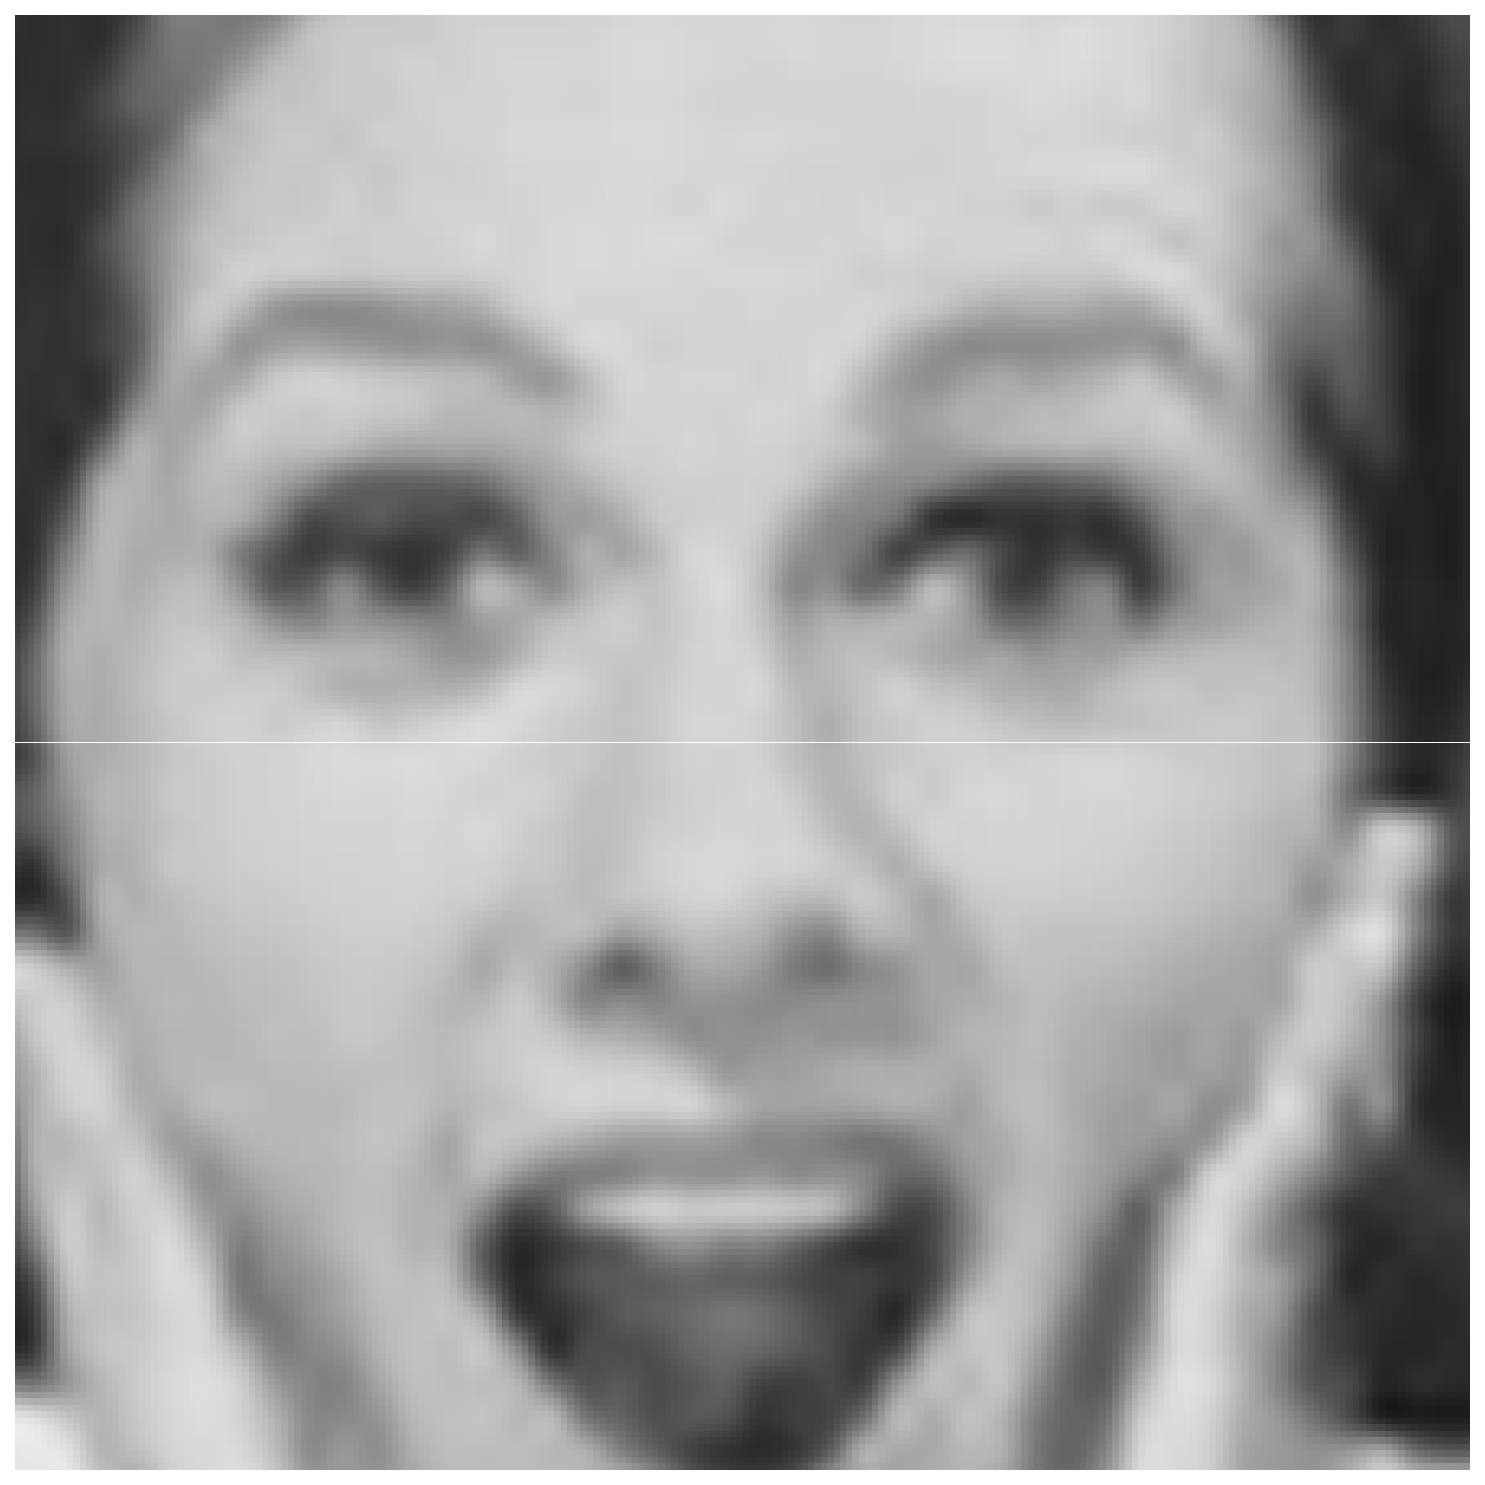

In [8]:
transforms1 = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=size, interpolation=3),
    torchvision.transforms.CenterCrop(crop_size),
    torchvision.transforms.ToTensor(),
])

sample1 = transforms1(Image.open(path).convert("RGB"))
patches = patchify(sample1.permute(1, 2, 0).numpy(), (16, 16, 3), step=16).squeeze(2)
print(patches[0, 0].shape)

fig, axs = plt.subplots(14, 14, figsize=(10, 10), dpi=150)

for i in range(14):
    for j in range(14):
        axs[i, j].imshow(patches[i, j])
        axs[i, j].axis('off')

plt.tight_layout()
plt.subplots_adjust(wspace=0., hspace=0.)
# plt.savefig('pics/exemplary_image_no_frame.png')
plt.show()

## Eyes and Mouth Patches

In [9]:
eyes = 0 * 14 + np.arange(2, 12)
eyes = list(eyes) + list(1 * 14 + np.arange(2, 12))
eyes = list(eyes) + list(2 * 14 + np.arange(2, 12))
eyes = list(eyes) + list(3 * 14 + np.arange(2, 12))
eyes = list(eyes) + list(4 * 14 + np.arange(2, 12))

mouth = 10 * 14 + np.arange(5, 10)
mouth = list(mouth) + list(11 * 14 + np.arange(5, 10))
mouth = list(mouth) + list(12 * 14 + np.arange(5, 10))
mouth = list(mouth) + list(13 * 14 + np.arange(5, 10))

not_mouth = list(set(symbxai_vit.node_domain) - set(mouth))
eyes_relevance = symbxai_vit.symb_or(eyes) + symbxai_vit.symb_or(not_mouth) - symbxai_vit.symb_or(eyes + not_mouth)
print(eyes_relevance)

not_eyes = list(set(symbxai_vit.node_domain) - set(eyes))
mouth_relevance = symbxai_vit.symb_or(not_eyes) + symbxai_vit.symb_or(mouth) - symbxai_vit.symb_or(not_eyes + mouth)
print(mouth_relevance)

eyes_and_mouth_relevance = symbxai_vit.symb_or(eyes) + symbxai_vit.symb_or(mouth) - symbxai_vit.symb_or(eyes + mouth)
print(eyes_and_mouth_relevance)

R_values = [eyes_relevance.item(), mouth_relevance.item(), eyes_and_mouth_relevance.item()]
R_values


tensor(2.6830)
tensor(3.0464)
tensor(0.9462)


[2.682955265045166, 3.046407699584961, 0.9462070465087891]

/var/folders/wh/dzlv3bps3ms61gjh0rl9y1r00000gp/T/ipykernel_37883/3167486055.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap_neg = matplotlib.cm.get_cmap('Blues')
/var/folders/wh/dzlv3bps3ms61gjh0rl9y1r00000gp/T/ipykernel_37883/3167486055.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap_pos = matplotlib.cm.get_cmap('Reds')


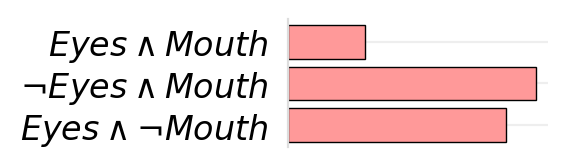

In [10]:
import matplotlib

plt.rcParams.update({'font.size': 12})
plt.rcParams.update({'hatch.linewidth': 0.5})
cmap_neg = matplotlib.cm.get_cmap('Blues')
cmap_pos = matplotlib.cm.get_cmap('Reds')

width=0.7
alpha = 1
labels = ['$Eyes \\wedge \\neg{Mouth}$', '$\\neg{Eyes} \wedge Mouth$', '$Eyes \\wedge Mouth$']
fig, ax = plt.subplots(1, figsize=(3, 1), dpi=200)

for i, value in enumerate(R_values):
    if i == 0:
        label = 'Eyes'
    elif i == 1:
        label = 'Mouth'
    else:
        label = 'Eyes & Mouth'
            
    if value < 0:
        blue_color = (.6,.6,1) # '#00BFFF'
        if label:
            # cmap_neg(abs(value))
            bars = ax.barh(i, value, alpha=alpha, edgecolor='black',
                          color=blue_color, linewidth=0.5, label=label)
        else:
            bars = ax.barh(i, value, alpha=alpha, edgecolor='black',
                          color=blue_color, linewidth=0.5)
    else:
        red_color = (1,0.6,0.6)
        if label:
            bars = ax.barh(i, value, alpha=alpha, edgecolor='black',
                          color=red_color, linewidth=0.5, label=label)
        else:
            bars = ax.barh(i, value, alpha=alpha, edgecolor='black',
                          color=red_color, linewidth=0.5)


ax.set_yticks(np.arange(len(R_values)), labels, rotation=0)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_color('#DDDDDD')
ax.tick_params(bottom=False, left=False)
ax.set_axisbelow(True)
ax.yaxis.grid(True, color='#EEEEEE')
ax.xaxis.grid(False)
# ax.set_xlim([-1,1])

ax.set_xticklabels('')
ax.set_xlabel('')
ax.set_facecolor("white")


if False:
    legend = ax.legend(title='Context', 
                       title_fontsize=12, 
                       fontsize=12, 
                       loc="upper center",
                       bbox_to_anchor=(-.1, .9))
    title = legend.get_title()
    title.set_weight('bold')

plt.tight_layout()
# plt.savefig('pics/query_attribution_fig1_vision.png')
plt.show()


# Individual attribution of each feature

In [11]:
from copy import copy

eyes_relevance = symbxai_vit.symb_or(eyes)
print('eyes', eyes_relevance)


mouth_relevance =  symbxai_vit.symb_or(mouth)
print('mouth', mouth_relevance)


rest = copy(symbxai_vit.node_domain)
for x in eyes: rest.remove(x)
for x in mouth: rest.remove(x)
    

rest_relevance = symbxai_vit.symb_or(rest)

print('rest', rest_relevance )

R_values = [eyes_relevance.item(), mouth_relevance.item(), rest_relevance.item()]
R_values

eyes tensor(2.6830)
mouth tensor(3.0464)
rest tensor(5.5726)


[2.682955026626587, 3.046407461166382, 5.572561740875244]